In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

from torchvision import utils
import matplotlib.pyplot as plt

import numpy as np
import time
import copy

In [4]:
data_path = './data/STL10'

if not os.path.exists(data_path):
    os.mkdir(data_path)
    
train_dataset = datasets.STL10(data_path, split='train', download=True, transform=transforms.ToTensor())
valid_dataset = datasets.STL10(data_path, split='test', download=True, transform=transforms.ToTensor())

print(len(train_dataset))
print(len(valid_dataset))

Files already downloaded and verified
Files already downloaded and verified
5000
8000


In [5]:
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_dataset]
train_stdRGB  = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_dataset]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])

train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

valid_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in valid_dataset]
valid_stdRGB  = [np.std(x.numpy(), axis=(1,2)) for x, _ in valid_dataset]

valid_meanR = np.mean([m[0] for m in valid_meanRGB])
valid_meanG = np.mean([m[1] for m in valid_meanRGB])
valid_meanB = np.mean([m[2] for m in valid_meanRGB])

valid_stdR = np.mean([s[0] for s in valid_stdRGB])
valid_stdG = np.mean([s[1] for s in valid_stdRGB])
valid_stdB = np.mean([s[2] for s in valid_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(train_stdR, train_stdG, train_stdB)

0.4467106 0.43980986 0.40664646
0.22414584 0.22148906 0.22389975


In [6]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize(
        [train_meanR, train_meanG, train_meanB],
        [train_stdR, train_stdG, train_stdB]
    ),
    transforms.RandomHorizontalFlip(),
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize(
        [valid_meanR, valid_meanG, valid_meanB],
        [valid_stdR, valid_stdG, valid_stdB]
    ),
    transforms.RandomHorizontalFlip(),
])

In [7]:
train_dataset.transform = train_transform
valid_dataset.transform = valid_transform

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image indices [ 235 3980  905 2763]


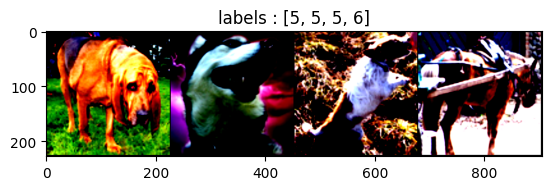

In [8]:
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_transpose = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_transpose)
    
    if y is not None:
        plt.title("labels : " + str(y))
        
np.random.seed(1)
torch.manual_seed(1)

grid_size = 4
rand_indices = np.random.randint(0, len(train_dataset), grid_size)
print('Image indices', rand_indices)

x_grid = [train_dataset[i][0] for i in rand_indices]
y_grid = [train_dataset[i][1] for i in rand_indices]

x_grid = utils.make_grid(x_grid, nrow=4, padding=2)
show(x_grid, y_grid)

In [9]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )
        
        self.shortcut = nn.Sequential()
        
        self.relu = nn.ReLU()
        
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [10]:
class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion)
        )
        
        self.shortcut = nn.Sequential()
        
        self.relu = nn.ReLU()
        
        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [11]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [12]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = resnet50().to(device)
x = torch.randn(3, 224, 224).unsqueeze(0).to(device)
output = model(x)
print(output.size())

torch.Size([1, 10])


In [13]:
summary(model, (1, 3, 224, 224), device="mps")

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─BottleNeck: 2-5                   [1, 256, 56, 56]          --
│    │    └─Sequential: 3-1              [1, 256, 56, 56]          58,112
│    │    └─Sequential: 3-2              [1, 256, 56, 56]          16,896
│    │    └─ReLU: 3-3                    [1, 256, 56, 56]          --
│    └─BottleNeck: 2-6                   [1, 256, 56, 56]          --
│    │    └─Sequential: 3-4              [1, 256, 56, 56]          70,400

In [14]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [15]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [16]:
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    return loss.item(), metric_b

In [17]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)
    
    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        
        output = model(xb)
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break
    
    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric

In [18]:
def train_val(model, params):
    num_epochs = params['num_epochs']
    loss_func = params['loss_func']
    opt = params['optimizer']
    train_dataloader = params['train_dataloader']
    valid_dataloader = params['valid_dataloader']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']
    
    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}
    
    best_loss = float('inf')
    start_time = time.time()
    
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dataloader, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)
        
        model.eval()
        
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, valid_dataloader, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)
        
        if val_loss < best_loss:
            best_loss = val_loss
            print('Get best validation model')
            torch.save(model.state_dict(), path2weights)
            print()
            
        lr_scheduler.step(val_loss)
        
        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' % (train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)
        
    return model, loss_history, metric_history

In [19]:
params_train = {
    'num_epochs': 10,
    'optimizer': opt,
    'loss_func': loss_func,
    'train_dataloader': train_dataloader,
    'valid_dataloader': valid_dataloader,
    'sanity_check': False,
    'lr_scheduler': lr_scheduler,
    'path2weights': './models/weights.pt'
}

def create_dir(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error')

create_dir('./models')

In [ ]:
model, loss_hist, metric_hist = train_val(model, params_train)